In [1]:
# create_scenario(city_size, rad_cen, depot_loc, density)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import glob
import networkx as nx
import numpy as np
import os
import cv2
import math
import random
import bisect
import copy
import pickle
from scipy.spatial import Voronoi, voronoi_plot_2d
from itertools import accumulate
from copy import deepcopy
from itertools import accumulate, combinations

from randomScatter import RandomScatter
from direction import Direction
from vertex import VertexBase, VertexOrigin, VertexLayer

def create_city(trialstr, city_size, num_centers, freq, op_start_time, op_end_time, batt_cap):
    width = 200
    height = 200
    buffer = 20
    num_radial_centres = num_centers
    if city_size == 50:
        city_name = 'small'
        path_num = 4
        scale = 20
    elif city_size == 100:
        city_name = 'medium'
        path_num = 8
        scale = 18
    elif city_size == 200:
        city_name = 'large'
        path_num = 12
        scale = 16

    circles = []
    
    filename = city_name + "/" + trialstr + "_cen_" + str(num_centers) + "_max_freq_" + str(freq)
    
    if not os.path.exists(city_name):
        os.mkdir(city_name)
    
    if not os.path.exists(filename):
        os.mkdir(filename)
        
    if os.path.exists(filename+"/out/lc.txt"):
        return 0
    
    for i in range(num_radial_centres):    
        for i in range(1000):
            radius = random.randint(20, 50)
            cen_x = random.randint(buffer+radius,width-buffer-radius)
            cen_y = random.randint(buffer+radius,height-buffer-radius)
            if not any(map(lambda circle: intersection(cen_x, circle[0],cen_y, circle[1],radius, circle[2]), circles)):
                circles.append((cen_x, cen_y, radius))
                break

    img = np.zeros((width,height))
    for circle in circles:
    #     cv2.circle(img, (circle[0],circle[1]),circle[2],(0),cv2.FILLED)
        cv2.circle(img, (circle[0],circle[1]),circle[2],(255),cv2.FILLED)
#         plt.imshow(img,cmap='Greys')
#         cv2.imwrite(city_name+"/"+trialstr+"/"+"/scatter_rate.jpg",img)

    num = 1
    for circle in circles:
        img2 = np.ones((width,height))*255
        cv2.circle(img2, (circle[0],circle[1]),circle[2],(0),cv2.FILLED)
        cv2.imwrite(filename+"/"+'circle'+str(num)+".jpg",img2)
        num += 1

    kernel = np.ones((7,7),np.float32)/(7**2)
    dst = cv2.filter2D(img,-1,kernel)**2/255

#     plt.imshow(dst,cmap='Greys')
    cv2.imwrite(filename+"/"+"scatter_rate.jpg",dst)


    ERROR_MESSAGE = '----------------------'
    IMAGE_INPUT_PATH = filename+"/"+'scatter_rate.jpg'
    IMAGE_OUTPUT_PATH = filename+"/"+'image_output/'
    ROADMAP_RECTANGLE = ['./image_input/roadMapRectangle_00.jpg']
    ROADMAP_CIRCLE = [i for i in glob.glob(filename+"/"+"circle*.jpg")]

    random.shuffle(ROADMAP_CIRCLE)

#     if not os.path.exists(IMAGE_OUTPUT_PATH):
#         os.mkdir(IMAGE_OUTPUT_PATH)

    randomScatterInstance = RandomScatter(IMAGE_INPUT_PATH, city_size, 0, reverse=True, squared=True)
    randomScatterInstance.readImage()
    randomScatterInstance.randomDots()
    randomScatterInstance.makePoints()

    #run improvePoints twice to refine points' locations
    randomScatterInstance.improvePoints(randomScatterInstance.points)
    _, graph, points = randomScatterInstance.improvePoints(randomScatterInstance.improvedPoints) * 1
#         print(points[0], 'b')
    directionInstance = Direction(ROADMAP_RECTANGLE, ROADMAP_CIRCLE)

    vertexLayertInstance = VertexLayer(randomScatterInstance, directionInstance)

#         plt.show()
#         fig = plt.figure(figsize=(10,10))
#         ax = plt.gca()
#         ax.set_xlim(left=0, right=randomScatterInstance.shape[1])
#         ax.set_ylim(top=height, bottom=0)#randomScatterInstance.shape[0])
#         plt.figure(1,figsize=(10,10)) 

    verts = []
    vertexlist={}
    vertexdem = {}
    c=0
    adjdict={}
    for i in range(20):
        vertexLayertInstance.getNextVertices()
        vertexLayertInstance.mergeNextVertices(5)
        vertexLayertInstance.mergeToAll(3)
        if len(vertexLayertInstance.verticesNext)<=3:
            vertexLayertInstance.changeNextVertices()
            break
#             vertexLayertInstance.plotLines(vertexLayertInstance.verticesNext, True)
        for i in vertexLayertInstance.verticesNext:
            if tuple(i.position) not in vertexlist:
                vertexlist[tuple(i.position)] = i.index
                verts.append(i.index)
                vertexdem[tuple(i.position)] = i.dem
#                 c+=1

        for i in vertexLayertInstance.verticesNext:
            for j in i.comesFrom:
                if tuple(i.position) not in vertexlist:
                    vertexlist[tuple(i.position)] = i.index
                    verts.append(i.index)
                    vertexdem[tuple(i.position)] = i.dem
#                     c+=1

                if tuple(j[0].position) in vertexlist:
                    if vertexlist[tuple(j[0].position)] in adjdict:
                        adjdict[vertexlist[tuple(j[0].position)]].update({vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}})
                    else:
                        adjdict[vertexlist[tuple(j[0].position)]] = {vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}}
                else:
                    vertexlist[tuple(j[0].position)] = j[0].index
                    verts.append(j[0].index)
                    vertexdem[tuple(j[0].position)] = j[0].dem
#                     c+=1
                    if vertexlist[tuple(j[0].position)] in adjdict:
                        adjdict[vertexlist[tuple(j[0].position)]].update({vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}})
                    else:
                        adjdict[vertexlist[tuple(j[0].position)]] = {vertexlist[tuple(i.position)]:{'weight':j[0].getDistance(i)}}

            for j in i.goesTo:
                if tuple(j[0].position) not in vertexlist:
                    vertexlist[tuple(j[0].position)] = j[0].index
                    verts.append(j[0].index)
                    vertexdem[tuple(j[0].position)] = j[0].dem
#                     c+=1

                if tuple(i.position) in vertexlist:
                    if vertexlist[tuple(i.position)] in adjdict:
                        adjdict[vertexlist[tuple(i.position)]].update({vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}})
                    else:
                        adjdict[vertexlist[tuple(i.position)]] = {vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}}
                else:
                    vertexlist[tuple(i.position)] = i.index
                    verts.append(i.index)
                    vertexdem[tuple(i.position)] = i.dem
#                     c+=1
                    if vertexlist[tuple(i.position)] in adjdict:
                        adjdict[vertexlist[tuple(i.position)]].update({vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}})
                    else:
                        adjdict[vertexlist[tuple(i.position)]] = {vertexlist[tuple(j[0].position)]:{'weight':i.getDistance(j[0])}}

        vertexLayertInstance.changeNextVertices()

    for i in vertexLayertInstance.verticesAll:
        if tuple(i.position) not in vertexlist:
            vertexlist[tuple(i.position)]=i.index
#             c+=1

    vertexlistinv = {v: k for k, v in vertexlist.items()}
#         vertexLayertInstance.plotVertices(vertexLayertInstance.verticesOrigin, alpha = 1.0)

    x_coor = []
    y_coor = []
    for ver in points:
        x_coor.append(ver[0])
        y_coor.append(ver[1])
#         plt.scatter(x_coor, y_coor, c='#00ff00', alpha = 1.0)

    vertexpos={}
    for k,v in vertexlistinv.items():
        pos=v
        vertexpos[k] = pos[::-1]

    G = nx.Graph(adjdict)
    G.remove_edges_from(nx.selfloop_edges(G))
    unneeded = []
    for n in G.nodes:
        if len(list(G.neighbors(n))) == 1:
            nbrs = list(G.neighbors(n))
            if len(list(G.neighbors(nbrs[0]))) > 2:
                unneeded.append(n)
    # print(unneeded)
    for i in range(len(unneeded)):
        G.remove_node(unneeded[i])
#         plt.figure(1,figsize=(10,10)) 
#         nx.draw(G, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_init.jpg')
#         plt.show()

    T = deepcopy(G)

    combs = list(combinations(G.nodes(), 2))
    nodes_to_remove = []
    edges_to_add = []
    for n1,n2 in combs:
    #     print(vertexpos[n1], vertexpos[n2])
        if n1 in T.nodes() and n2 in T.nodes():
            temp = math.sqrt((vertexpos[n1][0] - vertexpos[n2][0]) ** 2.0 + (vertexpos[n1][1] - vertexpos[n2][1]) ** 2.0)
            if temp < 3:# and n1 not in T.neighbors(n2):
                for n in T.neighbors(n1):
                    edges_to_add.append((n2, n))
                if n1 not in nodes_to_remove:
                    nodes_to_remove.append(n1)

    T.add_edges_from(edges_to_add) 
    for node in nodes_to_remove:
        T.remove_node(node)
    T.remove_edges_from(nx.selfloop_edges(T))
    # print(len(T.edges()))
#         fig = plt.figure(figsize=(10,10))
#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_wo_node.jpg')
#         plt.show()

    nw_points = []
    for ver in T.nodes():
        if len(list(T.neighbors(ver))) >= 4:
            nw_points.append(ver)

    nw_pts = deepcopy(nw_points)

#         plt.figure(1,figsize=(10,10)) 
    x_co = []
    y_co = []
    for ver in nw_points:
        x_co.append(vertexpos[ver][0])
        y_co.append(vertexpos[ver][1])

#         plt.scatter(x_co, y_co, c='#0000ff', alpha = 1.0)
#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node.jpg')
#         plt.show()

    temps = []
    for pt in points:
        nearest = 50000
        best_pt = None
        for nd in T.nodes():
            ver = vertexpos[nd]
            temp = math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(ver, pt)))

            key_v=vertexlist[ver[::-1]]
            if key_v in adjdict:
                deg=len(adjdict[key_v])
            else:
                deg=0.001
            vvv = (1/vertexdem[ver[::-1]])*(1/deg)*temp
            if vvv < nearest:
                best_pt = ver
                nearest = vvv

        temps.append(best_pt)

    for el in nw_points:
        temps.append(vertexpos[el])

#         print(len(temps))
    new_points = []
    for el in temps:
        if el not in new_points:
            new_points.append(el)
#         print(len(new_points))
    plt.figure(1,figsize=(10,10)) 
    x_co = []
    y_co = []
    for ver in new_points:
        x_co.append(ver[0])
        y_co.append(ver[1])

#         plt.scatter(x_co, y_co, c='#0000ff', alpha = 1.0)

#         nx.draw(T, vertexpos, node_size=10, font_size=8)
#         plt.savefig(city_name+"/"+trialstr+"/"+'graph_w_node2.jpg')

    vertexposinv={v:k for (k,v) in vertexpos.items()}
    labels = []
    for pt in new_points:
    #     print(pt)
        labels.append(vertexposinv[pt])
    
    base_graph = deepcopy(T)
    new_points_w_dep = deepcopy(new_points)
    v_pos = deepcopy(vertexpos)
    v_pos_inv = deepcopy(vertexposinv)
    
    nx.write_gpickle(base_graph, filename + "/base_graph.gpickle")
        
    with open(filename+"/"+'new_points_w_dep.pickle', 'wb') as handle:
        pickle.dump(new_points_w_dep, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(filename+"/"+'vertexpos.pickle', 'wb') as handle:
        pickle.dump(v_pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(filename+"/"+'vertexposinv.pickle', 'wb') as handle:
        pickle.dump(v_pos_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
#     depot_node_in = None
#     depot_node_out = None

    depot_node_in, depot_node_out = create_depot(new_points, circles, vertexposinv)
    
    if depot_node_in == depot_node_out:
#         print('AAAAAAAAA')
        return -1
    
    new_points.remove(depot_node_in[1])
    new_points.remove(depot_node_out[1])

    path_list, remaining = create_lines(new_points, T, vertexpos, vertexposinv, x_co, y_co, filename, path_num)
    
    case_in = filename + '/in'
    if not os.path.exists(case_in):
        os.mkdir(case_in)
    
    case_out = filename + '/out'
    if not os.path.exists(case_out):
        os.mkdir(case_out)
    
    updated_path_list_in, paths_with_dh_in, P_updated_in, P_w_dh_in = add_deadheads(T, path_list, remaining, depot_node_in, vertexpos, case_in, path_num)
    
    updated_path_list_out, paths_with_dh_out, P_updated_out, P_w_dh_out = add_deadheads(T, path_list, remaining, depot_node_out, vertexpos, case_out, path_num)
    
#     print(len(path_list), len(updated_path_list), len(paths_with_dh))
#     print(updated_path_list_in == updated_path_list_out, P_updated_in.nodes() == P_updated_out.nodes())
    
    if path_num == 4:
        freq_options = list(range(1, freq+1))
        freqs = []
        for i in range(2):
            fr = random.choice(freq_options)
            freqs.append(fr)
        
        new_freqs = []
        for fr in freqs:
            new_freqs.append(fr)
            new_freqs.append(fr)
            
    else:
        freq_options = list(range(1,freq))
        freqs = []
        most = math.floor(path_num/3)
        ct = 1

        for i in range(int(path_num/2)-1):
            fr = random.choice(freq_options)
            freqs.append(fr)

        for i in range(int(most/2)):
            freqs.append(freq)

        random.shuffle(freqs)

        print(len(freqs))

        new_freqs = []
        for fr in freqs:
            new_freqs.append(fr)
            new_freqs.append(fr)
    
#     print('eyyyyyy', len(updated_path_list_in), len(new_freqs))
    
    create_line_pool(updated_path_list_in, new_freqs, scale, op_start_time, op_end_time, batt_cap, vertexpos, case_in)
    
    create_line_pool(updated_path_list_out, new_freqs, scale, op_start_time, op_end_time, batt_cap, vertexpos, case_out)
    
    return 0
    
#     for path in path_list:
#         print(len(path))
#     '''
#     Things to pass:
#     new_points, x_co, y_co
#     vertexpos, vertexposinv, T, circles
#     '''
#     a = new_points , x_co, y_co, circles, vertexpos, vertexposinv#, T
#     c = nx.write_gpickle(T, "test.gpickle")
    
#     with open('filename.pickle', 'wb') as handle:
#         pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#     with open('filename.pickle', 'rb') as handle:
#         b = pickle.load(handle)
    
#     d  = nx.read_gpickle("test.gpickle")
    
# #     print('a', T)
# #     print('b', d)
#     print(a == b)
# #     print(c == d)

In [3]:
def create_depot(new_points, circles, vertexposinv):
    
#     if depot_loc == 'in':
    max_num = 0
    max_cen = None

    for circle in circles:
        pt_num = 0
        for pt in new_points:
            if math.sqrt((pt[0] - circle[0]) ** 2.0 + (pt[1] - circle[1]) ** 2.0) <= 30:
                pt_num += 1
        if pt_num > max_num:
            max_cen = (circle[0], circle[1])
            max_num = pt_num

    best_cand_in_dist = 20000
    best_cand_in = None

    for pt in new_points:
        dist = math.sqrt((pt[0] - max_cen[0]) ** 2.0 + (pt[1] - max_cen[1]) ** 2.0)
        if dist <= best_cand_in_dist:
            best_cand_in = pt
            best_cand_in_dist = dist

    best_cand_in_id = vertexposinv[best_cand_in]
#     dep_x_co, dep_y_co = max_cen
#     temp_x_co = [dep_x_co, best_cand[0]]
#     temp_y_co = [dep_y_co, best_cand[1]]

#         new_points_copy = deepcopy(new_points)
#         new_points.remove(best_cand)

    depot_in = [best_cand_in_id, best_cand_in]

#     else:
    min_num = 20000
    min_cen = None

    for circle in circles:
        pt_num = 0
        for pt in new_points:
            if math.sqrt((pt[0] - circle[0]) ** 2.0 + (pt[1] - circle[1]) ** 2.0) <= 30:
                pt_num += 1
    #     print(pt_num, circle)
        if pt_num < min_num:
            min_cen = (circle[0], circle[1])
            min_num = pt_num

#             print(min_cen, min_num)

    best_cand_out_dist = 2000000
    best_cand_out = None

    for pt in new_points:
        dist = math.sqrt((pt[0] - min_cen[0]) ** 2.0 + (pt[1] - min_cen[1]) ** 2.0)
        if dist <= best_cand_out_dist:
            best_cand_out = pt
            best_cand_out_dist = dist

    best_cand_out_id = vertexposinv[best_cand_out]
#     dep_x_co, dep_y_co = min_cen
#     temp_x_co = [dep_x_co, best_cand[0]]
#     temp_y_co = [dep_y_co, best_cand[1]]

#     new_points_copy = deepcopy(new_points)
#     print(max_cen, min_cen)
#     print(best_cand_in, best_cand_out)

    depot_out = [best_cand_out_id, best_cand_out]

    return (depot_in, depot_out)

In [4]:
def create_lines(new_points, T, vertexpos, vertexposinv, x_co, y_co, filename, path_num):
    visited = []
    path_list = []

    paths = []

    for n1, n2 in combinations(new_points, 2):
        paths.append(nx.shortest_path(T, vertexposinv[n1], vertexposinv[n2]))

    '''
    for pts in new_points, split into pairs (preferably diametrically opposite)
    try to grow shortest path between pairs, including 
    '''
    path_list = []

    for pt in new_points:
        direction = (200-pt[0], 200-pt[1])
        nearest = 5000
        best_pt = None
        for ver in new_points:
            temp = math.sqrt((direction[0] - ver[0]) ** 2.0 + (direction[1] - ver[1]) ** 2.0)
            if temp < nearest:
                best_pt = ver
                nearest = temp
        path_list.append(nx.shortest_path(T,vertexposinv[pt],vertexposinv[best_pt]))

#     print('-'*100)
#     print(len(path_list))

    removed = []
    for i in range(len(path_list)):
        for j in range(i+1,len(path_list)):
            temp_1 = None
            temp_2 = None
            if len(path_list[i]) >= len(path_list[j]):
                temp_1 = path_list[i]
                temp_2 = path_list[j]
            else:
                temp_1 = path_list[j]
                temp_2 = path_list[i]
            if len(set(temp_1).intersection(set(temp_2))) >= 0.65*len(temp_2):
                if temp_2 not in removed:
                    removed.append(temp_2)

#     print(len(removed))

    for i in removed:
        path_list.remove(i)

#     print(len(path_list))
#     print('-'*100)
    
    rem = []
    for path in path_list:
    #     print(len(path))
        if len(path) < 20:
            rem.append(path)

    for path in rem:
        path_list.remove(path)
    
    if len(path_list) > path_num:
        path_list.sort(key = lambda tup: -len(tup))
        rem = []
        
        for i in range(path_num, len(path_list)):
            rem.append(path_list[i])
        
        for path in rem:
            path_list.remove(path)
            
    
#     print(len(path_list))
#     print('-'*100)

    '''
    look at all remaining stops
    pick end node of path, iteratively connect to nearest stop until cannot find more

    '''
    covered = []
    for path in path_list:
        for el in path:
            if el not in covered and vertexpos[el] in new_points:
                covered.append(el)
    remaining = [vertexposinv[el] for el in new_points]
    # print(remaining)
    for pt in covered:
        remaining.remove(pt)

#     longest = []
#     for n1, n2 in combinations(remaining,2):
#         pth = nx.shortest_path(T, n1, n2)
#         if any(i in covered for i in pth) == False:
#             if len(pth) >= len(longest):
#                 longest = pth

#     rem_x_co = []
#     rem_y_co = []
#     for ver in remaining:
#         rem_x_co.append(vertexpos[ver][0])
#         rem_y_co.append(vertexpos[ver][1])

    P = nx.Graph()
    edges = []
    for path in path_list:
        path_edges = [(path[n], path[n+1]) for n in range(len(path)-1)]
        P.add_nodes_from(path)
        P.add_edges_from(path_edges)
        edges.append(path_edges)

    pos = nx.spring_layout(P)
    colors = get_cmap(len(path_list))

    linewidths = [2*i for i in range(len(path_list))]

    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS=len(edges)

#     if not os.path.exists(filename+"/graph_edges/"):
#         os.mkdir(filename+"/graph_edges/")

    pos = nx.spring_layout(P)
    colors = get_cmap(len(path_list))
    linewidths = [2*i for i in range(len(path_list))]
    
#     print('eyyyyy')
    plt.figure(figsize=(10,10))

    nx.draw(T, vertexpos, node_size=1, font_size=8, alpha=0.1, width=0.5)

    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS=len(edges)
    for ctr, edgelist in enumerate(edges):
        plt.scatter(x_co, y_co, c='#000000', alpha = 0.0)
#         plt.scatter(rem_x_co, rem_y_co, c='#FFA500', alpha = 0.0)
        nx.draw_networkx_edges(P, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.3, width = 4 ,node_size= 10)

    plt.savefig(filename+"/"+'paths.png')
#     plt.show()
    
    return (path_list, remaining)

In [5]:
def add_deadheads(T, path_list, remaining, depot_node, vertexpos, filename, path_num):
    possible_new_paths = []

    for n1, n2 in combinations(remaining,2):
        pth = nx.shortest_path(T, n1, n2)
        if len(pth) >= 20:
            possible_new_paths.append(pth)

#     print(len(possible_new_paths), 'a')

    removed_new = []

    for i in range(len(possible_new_paths)):
        common = 0
        temp_1 = possible_new_paths[i]
        for j in range(len(path_list)):
            temp_2 = path_list[j]
            if len(set(temp_1).intersection(set(temp_2))) >= 0.7*len(temp_2):
                if temp_1 not in removed_new:
                    removed_new.append(temp_1)

#     print(len(removed_new), 'b')

    for path in removed_new:
        possible_new_paths.remove(path)

    remo = []
    for i in range(len(possible_new_paths)):
        for j in range(i+1,len(possible_new_paths)):
            temp_1 = None
            temp_2 = None
            if len(possible_new_paths[i]) >= len(possible_new_paths[j]):
                temp_1 = possible_new_paths[i]
                temp_2 = possible_new_paths[j]
            else:
                temp_1 = possible_new_paths[j]
                temp_2 = possible_new_paths[i]
            if len(set(temp_1).intersection(set(temp_2))) >= 0.5*len(temp_2):
                if temp_2 not in remo:
                    remo.append(temp_2)

#     print(len(remo), 'd')

    for path in remo:
        possible_new_paths.remove(path)

#     print(len(possible_new_paths), 'possible new paths')

    possible_new_paths.sort(key = lambda tup: -len(tup))

    new_path_list = deepcopy(path_list)
    extra = min(path_num - len(path_list), len(possible_new_paths))
#     print(extra)

    for path in range(extra):
        new_path_list.append(possible_new_paths[path])
    
#     print(new_path_list[0], new_path_list[1])

    # NEW SET OF PATHS
    Y = nx.Graph()
    ejs = []
    for path in new_path_list:
        ej = [(path[n], path[n+1]) for n in range(len(path)-1)]
        Y.add_nodes_from(path)
        Y.add_edges_from(ej)
        ejs.append(ej)

    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS=len(ejs)

#     plt.figure(figsize=(10,10))
# #     plt.scatter(x_co, y_co, c='#0000ff', alpha = 0.3)
# #     plt.scatter(rem_x_co, rem_y_co, c='#000000', alpha = 1.0)
#     nx.draw(T, vertexpos, node_size=10, alpha = 0.2, font_size=8,width=0.5)

#     for ctr, edgelist in enumerate(ejs):
#     #     plt.figure(figsize=(10,10))
#     #     plt.scatter(x_co, y_co, c='#0000ff', alpha = 0.3)
#     #     plt.scatter(rem_x_co, rem_y_co, c='#000000', alpha = 1.0)
#     #     nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)
#         nx.draw_networkx_edges(Y, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.5, width = 4 ,node_size= 10)
#     #     plt.show()
#     plt.show()
    
    '''
    CHECK
    '''
    new_paths = deepcopy(new_path_list)
    deadhead_paths = []
    cov = []

#     Q = deepcopy(Y)
    Q = deepcopy(T)
    
    for path in new_paths:
        temp_1 = nx.shortest_path(Q, depot_node[0], path[0])
        temp_2 = nx.shortest_path(Q, depot_node[0], path[-1])
        if len(temp_1) < len(temp_2):
            deadhead_paths.append(temp_1)
        else:
            deadhead_paths.append(temp_2)

#     print(len(new_paths))
#     print(len(deadhead_paths))

#     all_paths = deadhead_paths + new_paths

#     print(len(all_paths))

    # PATHS WITH DEADHEAD TRIPS
    Z = nx.Graph()
    ejs = []
    for path in deadhead_paths:
        ej = [(path[n], path[n+1]) for n in range(len(path)-1)]
        Z.add_nodes_from(path)
        Z.add_edges_from(ej)
        ejs.append(ej)

    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS=len(ejs)
    
    dep = depot_node
    
    with open(filename+"/"+'depot_node.pickle', 'wb') as handle:
        pickle.dump(dep, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    nx.write_gpickle(Y, filename + "/updated_path_graph.gpickle")
    nx.write_gpickle(Z, filename + "/deadhead_path_graph.gpickle")

#     plt.figure(figsize=(10,10))
# #     plt.scatter(x_co, y_co, c='#0000ff', alpha = 0.3)
# #     plt.scatter(rem_x_co, rem_y_co, c='#000000', alpha = 1.0)
#     nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)

#     for ctr, edgelist in enumerate(ejs):
#     #     plt.figure(figsize=(10,10))
#     # #     plt.scatter(x_co, y_co, c='#0000ff', alpha = 0.3)
#     #     plt.scatter(rem_x_co, rem_y_co, c='#000000', alpha = 1.0)
#     #     nx.draw(T, vertexpos, node_size=10, font_size=8,width=0.5)
#         nx.draw_networkx_edges(Z, pos=vertexpos, edgelist=edgelist, edge_color = cm(ctr/NUM_COLORS), alpha = 0.5, width = 4 ,node_size= 10)
#     #     plt.show()
#     plt.show()
    return (new_path_list, deadhead_paths, Y, Z)

In [6]:
def create_line_pool(path_list, freqs, scale, op_start_time, op_end_time, batt_cap, vertexpos, filename):
    
    line_pool = {}
    times = [0.0, 0.25, 0.33]
    line_id = 1
    speed = 35
    ctr = 0
#     print(scale)
#     print(len(freqs))
    for path in path_list:
#         print(ctr)
        path_length = 0
        for i in range(1,len(path)):
            dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
            path_length += dist

        start_time = op_start_time + random.choice(times)
        fuel_con = round(path_length/scale, 2)
        duration = round(fuel_con/speed, 2)
        freq = freqs[ctr]
        nxt_start_time = round(start_time + (1/freq) + 0.25 - 1,2)
        line_pool['l'+str(line_id)] = (path[0], path[-1], start_time, duration, freq, vertexpos[path[0]], fuel_con)
        line_id += 1
        line_pool['l'+str(line_id)] = (path[-1], path[0], nxt_start_time, duration, freq, vertexpos[path[-1]], fuel_con)
        line_id += 1
        
        ctr += 1

    with open(filename+'/lc.txt', 'w') as f:
        f.write('# line-id; start_node_id; end_node_id; start_time; duration; frequency; co-ordinates, length')
    #     f.write('\n')
        for line in line_pool.items():
            f.write('\n')
            f.write(line[0] + ';' + str(line[1][0]) + ';' + str(line[1][1]) + ';' + str(line[1][2]) + ';' + str(line[1][3]) + ';' + str(line[1][4]) + ';' + str(line[1][5]) + ';' + str(line[1][6]) + ';')

In [7]:
def intersection(x1,x2,y1,y2,r1,r2):
    d = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    if d < r1 + r2 + 20:
        return True
    else:
        return False

def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)


In [8]:
def create_inst(params):
    trialstr, city_size,num_centers, freq, op_start_time, op_end_time, batt_cap=params
    x = create_city(str(trialstr), city_size, num_centers, freq, op_start_time, op_end_time, batt_cap)
#             create_city(trialstr, city_size, num_centers, freq, op_start_time, op_end_time, batt_cap):
    while x == -1:
        print(x)
        x = create_city(str(trialstr), city_size, num_centers, freq, op_start_time, op_end_time, batt_cap)
    print("-----------------------------------------------------------------------------------------------")
    

In [9]:
print(list(range(1,2)))

[1]


In [10]:
# city=['small','medium']
# centers=[2,3]
# freq=[2,3]
# params=[]
# for cityname in city:
#     for numc in centers:
#         for f in freq:
#             for trialstr in range(1,26):
# #                 print(trialstr)
#                 if cityname=='small':
#                     citysize=50
#                 elif cityname=='medium':
#                     citysize=100
#                 params.append([str(trialstr), citysize, numc, f, 7.0, 23.0, 120])

# #can be paralellized?
# for param in params:
#     create_inst(param)

[129.34387584013876, 288.5286895384012] a
[51.13458971567235, -19.46267637214836] a
[120.05296861763628, -21.511516458891407] a
[-14.785672464114864, 88.18577015861354] a
CENTER [132, 69]
CENTER [153, 151]
CENTER [67, 134]
[<vertex.VertexDescendant object at 0x000002619B8DD608>, -0.0] aaaaaaaaaaaa
No vertex was added!
-----------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

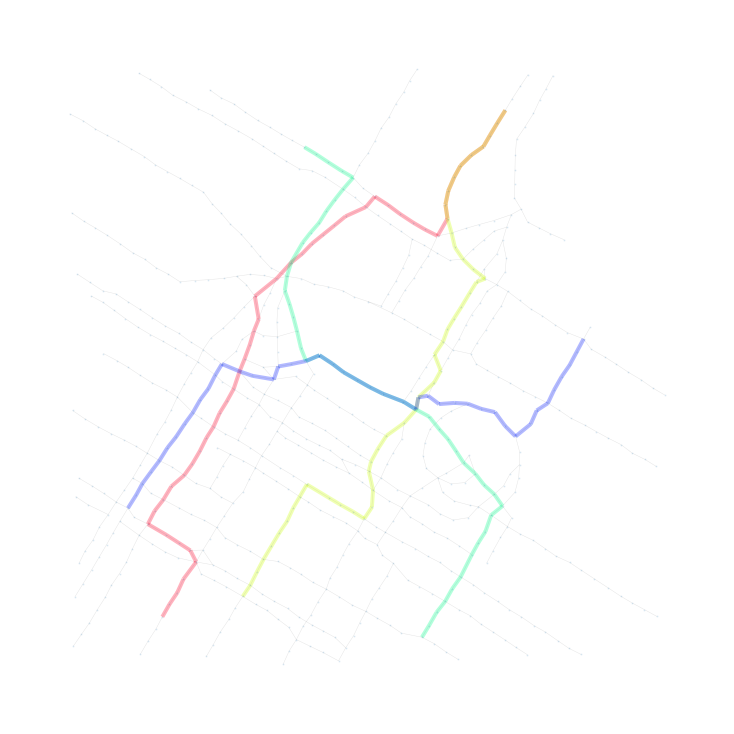

In [13]:
create_inst(['2', 50, 3, 2, 7.0, 23.0, 120])

In [14]:
from ast import literal_eval as make_tuple
import networkx as nx
import pickle

ctr = 0
lcon = {}

f = open("small/2_cen_3_max_freq_2/in/lc.txt", "r")
for line in f:
    l = [el for el in line.split(';')]
    if ctr != 0:
        lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
#     if ctr > 2:
#         break
    ctr+=1

for line in lcon.items():
    print(line)

# pool.map(create_inst, params)

                
# # x = create_city('1', 50, 3, 2, 7.0, 23.0, 120)
# # while x == -1:
# #     x = create_city('1', 50, 3, 2, 7.0, 23.0, 120)

('l1', [2415, 2169, 7.25, 0.38, 2, (28.690223508209957, 12.897150812163812), 13.35])
('l2', [2169, 2415, 7.0, 0.38, 2, (148.49263972057716, 189.07640427962977), 13.35])
('l3', [2169, 1958, 7.25, 0.34, 2, (148.49263972057716, 189.07640427962977), 11.96])
('l4', [1958, 2169, 7.0, 0.34, 2, (56.77233107030683, 19.989867279246294), 11.96])
('l5', [1808, 2266, 7.33, 0.34, 2, (119.35767562451394, 5.79340647056775), 11.81])
('l6', [2266, 1808, 7.08, 0.34, 2, (78.31685863227092, 176.2353745589137), 11.81])
('l7', [1862, 2466, 7.0, 0.32, 2, (16.67488130052826, 50.69500867384068), 11.18])
('l8', [2466, 1862, 6.75, 0.32, 2, (175.81494631533178, 109.52571818222317), 11.18])


In [78]:
# Desktop/test_code/small/5_cen_3_max_freq_2/in/depot_node.pickle

with open('small/5_cen_3_max_freq_2/vertexpos.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [81]:
print(len(b.keys()))

752


In [14]:
# # a = [0,1,2,3,4,5,6,7,8,9,10]
# # for i in range(8, len(a)):
# #     print(a[i])
    
# # b = 3
# # fr = list(range(1,b))
# # print(fr)

# freq = 3
# path_num = 4

# # print(path_num/2)

# freq_options = list(range(1,freq))
# print(freq_options)
# freqs = []
# most = math.floor(path_num/3)
# print(most)
# ct = 1
# print(path_num - most)
# for i in range(int(path_num/2)-1):
#     fr = random.choice(freq_options)
#     freqs.append(fr)

# for i in range(int(most/2)):
#     freqs.append(freq)

# random.shuffle(freqs)

# new_freqs = []
# for fr in freqs:
#     new_freqs.append(fr)
#     new_freqs.append(fr)


In [15]:
# from ast import literal_eval as make_tuple

# ctr = 0
# lcon = {}
# f = open("test_lc.txt", "r")
# for line in f:
#     l = [el for el in line.split(';')]
#     if ctr != 0:
#         lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
# #     if ctr > 2:
# #         break
#     ctr+=1

# for l in lcon.items():
#     print(l)

In [16]:
# def station_dist(line_pool, T):
#     dists = {}
# #     stations = [depot]
#     for line in line_pool.values():
#         print(line)
#         if line[0] not in stations:
#             stations.append([line[0], line[5]])
    
#     print(stations)
#     for s1, s2 in combinations(stations, 2):
#         if s1[0] not in dists.keys():
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s1[0]] = [[s2[0], round(path_length/10, 2)]]
#         else:
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s1[0]].append([s2[0], round(path_length/10, 2)])
        
#         if s2[0] not in dists.keys():
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s2[0]] = [[s1[0], round(path_length/10, 2)]]
#         else:
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s2[0]].append([s1[0], round(path_length/10, 2)])
    
#     for node in dists.keys():
#         dists[node].append([node, 0.0])
#     return dists


In [17]:
# def station_dist(line_pool, T, depot, stations, stat_dist):
#     dists = {}
# #     stations = [depot]
# #     for line in line_pool.values():
# # #         print(line)
# #         if line[0] not in stations:
# #             stations.append([line[0], line[5]])
    
# #     print(stations)
#     for s1, s2 in combinations(stations, 2):
#         if s1[0] not in dists.keys():
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s1[0]] = [[s2[0], round(path_length/10, 2)]]
#         else:
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s1[0]].append([s2[0], round(path_length/10, 2)])
        
#         if s2[0] not in dists.keys():
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s2[0]] = [[s1[0], round(path_length/10, 2)]]
#         else:
#             path = nx.shortest_path(T, s1[0], s2[0])
#             path_length = 0
#             for i in range(1,len(path)):
#                 dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
#                 path_length += dist
                    
#             dists[s2[0]].append([s1[0], round(path_length/10, 2)])
    
#     for node in dists.keys():
#         dists[node].append([node, 0.0])
#     return dists
